In [1]:
import sys
import os
import yaml
import torch
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(os.path.abspath('..'))
from src.data_loader import fetch_and_process, fetch_portfolio_data
from src.regime import get_regime_states
from src.graph import build_graph_from_correlations

with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [2]:
# Re-fetch data (or load from disk if you saved it)
spy_df = fetch_and_process(config['data']['market_ticker'], config['data']['start_date'], config['data']['end_date'])
spy_df = get_regime_states(spy_df)

portfolio_rets = fetch_portfolio_data(config['data']['portfolio_tickers'], config['data']['start_date'], config['data']['end_date'])

# Align dates
common_dates = spy_df.index.intersection(portfolio_rets.index)
spy_df = spy_df.loc[common_dates]
portfolio_rets = portfolio_rets.loc[common_dates]

# Extract "Bull" vs "Crash" Data
bull_data = portfolio_rets[spy_df['regime'] == 0]
crash_data = portfolio_rets[spy_df['regime'] == 2]

print(f"Bull Days: {len(bull_data)} | Crash Days: {len(crash_data)}")

Fitting HMM with 3 states...
Bull Days: 1665 | Crash Days: 570


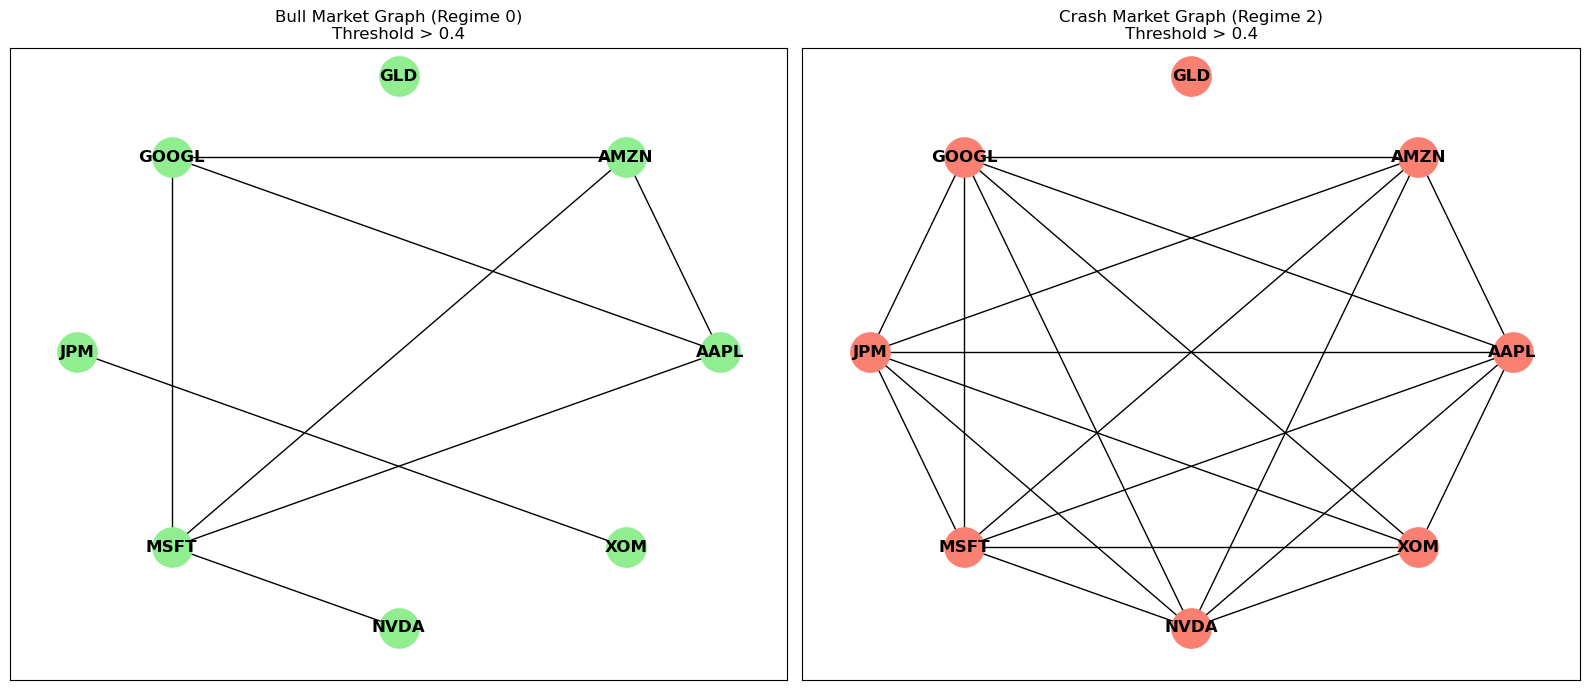

In [3]:
def plot_side_by_side_graphs(df_bull, df_crash, threshold=0.5):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    # 1. Bull Graph
    _, G_bull = build_graph_from_correlations(df_bull, threshold=threshold)
    pos_bull = nx.circular_layout(G_bull)
    
    ax1.set_title(f"Bull Market Graph (Regime 0)\nThreshold > {threshold}")
    nx.draw_networkx(G_bull, pos_bull, ax=ax1, node_color='lightgreen', node_size=800, font_weight='bold')
    # Draw edge weights
    bull_weights = [f"{d['weight']:.2f}" for u, v, d in G_bull.edges(data=True)]
    
    # 2. Crash Graph
    _, G_crash = build_graph_from_correlations(df_crash, threshold=threshold)
    pos_crash = nx.circular_layout(G_crash)
    
    ax2.set_title(f"Crash Market Graph (Regime 2)\nThreshold > {threshold}")
    # In crashes, we often see denser connections or different clusters
    nx.draw_networkx(G_crash, pos_crash, ax=ax2, node_color='salmon', node_size=800, font_weight='bold')

    plt.tight_layout()
    plt.show()

# Run Visualization
plot_side_by_side_graphs(bull_data, crash_data, threshold=0.4)